In [1]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from alpaca_trade_api.rest import REST, TimeFrame
import hvplot.pandas
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

In [2]:
def fetch_stock_data(start_date, end_date, tickers, timeframe = '1Day'):
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    api = REST(alpaca_api_key, alpaca_secret_key, base_url = 'https://paper-api.alpaca.markets')
    start_date_iso = pd.Timestamp(start_date, tz = 'America/New_York').isoformat()
    end_date_iso = pd.Timestamp(end_date, tz = 'America/New_York').isoformat()
    
    df_ticker = api.get_bars(tickers, TimeFrame.Day, start = start_date_iso, end = end_date_iso).df
    dfs = {}
    for ticker in tickers:
        ticker_df = df_ticker.loc[df_ticker.symbol == ticker].drop('symbol', axis = 1)
        ticker_df = ticker_df['close']
        dfs[ticker] = ticker_df
    new_df = pd.concat(dfs.values(), axis = 1, keys = tickers)
    return new_df

def weights(stock_list, num_simulations):
    all_lists = []
    num_assets = len(stock_list)
    for _ in range(num_simulations):
        random_weights = gen_random_weights(num_assets)
        all_lists.append(random_weights)
    if num_simulations == 1:
        all_lists = all_lists[0]
    return all_lists

def gen_random_weights(num_weights):
    weights = [random.random() for _ in range(num_weights)]
    normalized_weights = [round(w/sum(weights), 4) for w in weights]
    if sum(normalized_weights) != 1:
        return gen_random_weights(num_weights)
    
    return normalized_weights

In [3]:
load_dotenv()

True

In [4]:
stock_list = ['AAPL', 'KO', 'SBUX', 'WMT']
df = fetch_stock_data('2017-01-01', '2020-01-01', stock_list)

In [5]:
df

,AAPL,KO,SBUX,WMT
timestamp,,,,
2017-01-03 05:00:00+00:00,116.15,41.80,55.350,68.66
2017-01-04 05:00:00+00:00,116.02,41.65,55.990,69.06
2017-01-05 05:00:00+00:00,116.61,41.75,56.460,69.21
2017-01-06 05:00:00+00:00,117.91,41.74,57.130,68.26
2017-01-09 05:00:00+00:00,118.99,41.32,58.200,68.71
...,...,...,...,...
2019-12-24 05:00:00+00:00,284.27,54.71,88.520,119.51
2019-12-26 05:00:00+00:00,289.91,55.02,88.075,119.52
2019-12-27 05:00:00+00:00,289.80,55.35,88.130,119.59


In [6]:
stock_list2 = ['CAT', 'WMT', 'NVDA', 'DAL', 'NKE']
df_2 = fetch_stock_data('2017-01-01', '2020-01-01', stock_list2)

In [7]:
df_2

,CAT,WMT,NVDA,DAL,NKE
timestamp,,,,,
2017-01-03 05:00:00+00:00,93.99,68.66,102.01,49.48,51.98
2017-01-04 05:00:00+00:00,93.57,69.06,104.39,50.70,53.07
2017-01-05 05:00:00+00:00,93.00,69.21,101.74,49.73,53.06
2017-01-06 05:00:00+00:00,93.04,68.26,103.10,49.68,53.91
2017-01-09 05:00:00+00:00,92.37,68.71,107.28,49.69,53.38
...,...,...,...,...,...
2019-12-24 05:00:00+00:00,147.48,119.51,238.62,59.39,100.14
2019-12-26 05:00:00+00:00,148.22,119.52,239.19,59.56,100.71
2019-12-27 05:00:00+00:00,148.28,119.59,236.87,59.08,101.57


In [8]:
def portfolio_return(stock_df, weight_list):
    # Calculate the daily returns of stocks
    daily_return = stock_df.pct_change().dropna()
    # Calculate the mean of daily returns, and dot product it with their weights to find the portfolio mean
    portfolio_mean = daily_return.dot(weight_list).mean()
    return portfolio_mean



def portfolio_risk(stock_df, weight_list):
    # Calculate the daily retuns of stocks
    daily_return = stock_df.pct_change()
    # Find covariance matrix of the stocks
    cov_matrix = daily_return.cov()
    # Change weight lists into a vector
    weight_mat = np.matrix(weight_list)
    # Use the formula for portfolio risk (standard deviation) which is (w * sigma * w.T)^(0.5) where w is the weight vector and sigma is the covariance matrix
    portfolio_risk = np.sqrt(np.dot(np.dot(weight_mat, cov_matrix), weight_mat.T)).item()
    return portfolio_risk

In [9]:
def mc_sim(df, weight_list, timeframe, nsims, investment_amount = 1, kind = 'line'):
    # Calulate the portfolio return and risk
    port_return = portfolio_return(df, weight_list)
    port_risk = portfolio_risk(df, weight_list)
    # Create a framework for all the simulations
    all_simulations = np.full(shape = (timeframe, nsims), fill_value = 0.0)
    # For each simulation, it generates one numpy array, assigns randomless according to the portfolio return and risk, then finds cumulative return of that simulation.
    # Each created simulation then will be interted into the all_simulations framework
    for i in range(0, nsims):
        one_simulation = np.ones(shape = (timeframe, 1))
        rand = np.random.normal(port_return, port_risk, timeframe).T.reshape((timeframe,1))
        simulations = np.cumprod(one_simulation + rand) * investment_amount
        all_simulations[:,i] = simulations
    # Convert the created simulations into dataframe
    sim_df = pd.DataFrame(all_simulations)
    # If line is chosen, line graphs of all the simulations will be displayed
    if kind == 'line':
        plt.plot(all_simulations)
        plt.title('Monte Carlo Simulation of portfolio')
        plt.xlabel('Days')
        plt.ylabel('Portfolio value')
    # IF kde is chosen, the KDE plot of the simulations' last day will be displated
    elif kind == 'kde':
        ax = sim_df.iloc[-1,:].hvplot.kde(alpha = 0.1, title = 'KDE plot of the end result of Monte Carlo Simulation', yformatter = '%.5f', frame_width = 700, frame_height = 400)
        display(ax)

    return sim_df

In [10]:
sim_df = mc_sim(df, [0.25, 0.25, 0.25, 0.25], 252, 500, kind = 'kde')

:Distribution   [251]   (Density)

In [11]:
def mc_sim_comparison(df, df2, length, nsims, my_weights, your_weights, investment_amount = 1):
    # This function compares two different simulations
    # Show first simulation
    plt.figure()
    my_df = mc_sim(df, my_weights, length, nsims, investment_amount)
    plt.title('Portfolio 1')
    # Show second simulation
    plt.figure()
    your_df = mc_sim(df2, your_weights, length, nsims, investment_amount)
    plt.title('Portfolio 2')
    # Show the KDE plots of each simulations of their ending days together
    plt.figure()
    sns.kdeplot(my_df.iloc[-1,:], shade = True, alpha = 0.1, label = 'Portfolio 1')
    sns.kdeplot(your_df.iloc[-1,:], shade = True, alpha = 0.1, label = 'Portfolio 2')
    plt.title('Comparison of KDE plots for each portfolio')
    plt.legend()

In [12]:
my_weight = weights(stock_list,1)
your_weight = weights(stock_list2,1)

In [13]:
print(my_weight)
print(your_weight)

[0.3969, 0.2037, 0.2442, 0.1552]
[0.1428, 0.0858, 0.285, 0.2354, 0.251]


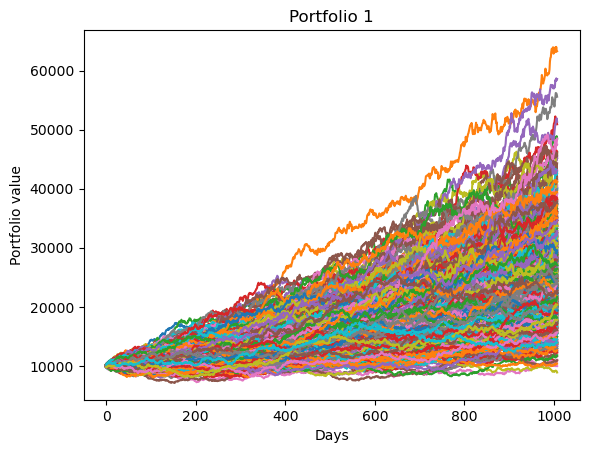

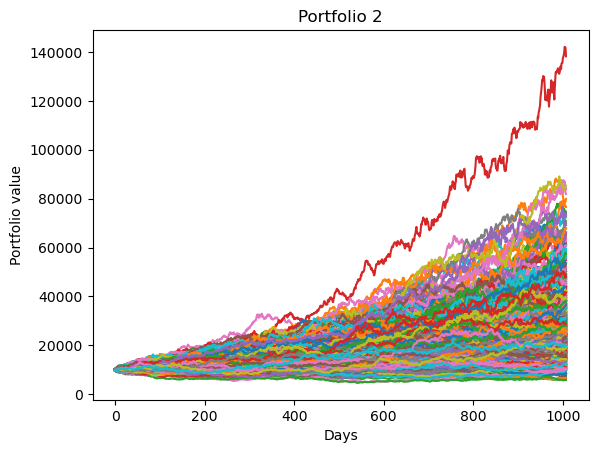

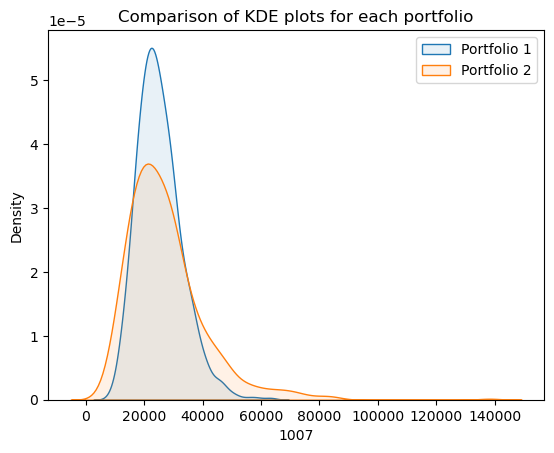

In [14]:
mc_sim_comparison(df, df_2, 252*4, 700, my_weight, your_weight, 10000)

In [15]:
def calculate_percentile(row, percentile):
    return np.percentile(row, percentile)

In [16]:
def graph_2(sim_df):
    original_sim_df = sim_df.copy()
    percentiles = [2.5, 25, 75, 97.5]
    sim_df['median'] = sim_df.median(axis = 1)
    for i in range(len(percentiles)):
        sim_df[f'percentile_{i}'] = sim_df.iloc[:,:-(i+1)].apply(lambda row: calculate_percentile(row, percentiles[i]), axis = 1)
    
    x = np.linspace(0, sim_df.shape[0], sim_df.shape[0])
    smooth_x = np.linspace(0, sim_df.shape[0], 3)
    
    f_1 = interp1d(x, sim_df['percentile_0'], kind='cubic')
    f_2 = interp1d(x, sim_df['percentile_1'], kind = 'cubic')
    f_3 = interp1d(x, sim_df['percentile_2'], kind = 'cubic')
    f_4 = interp1d(x, sim_df['percentile_3'], kind = 'cubic')
    f_5 = interp1d(x, sim_df['median'], kind = 'cubic')
    
    y_1_smooth = f_1(smooth_x)
    y_2_smooth = f_2(smooth_x)
    y_3_smooth = f_3(smooth_x)
    y_4_smooth = f_4(smooth_x)
    y_5_smooth = f_5(smooth_x)
    
    fig, ax = plt.subplots()
    
    plt.plot(original_sim_df, alpha = 0.05)
    ax.plot(smooth_x, y_1_smooth, alpha = 0)
    ax.plot(smooth_x, y_2_smooth, alpha = 0)
    ax.plot(smooth_x, y_3_smooth, alpha = 0)
    ax.plot(smooth_x, y_4_smooth, alpha = 0)
    ax.plot(smooth_x, y_5_smooth, alpha = 0.7, color = 'k', label = 'Median')

    ax.fill_between(smooth_x, y_1_smooth, y_4_smooth, alpha = 0.2, label = '95% CI')
    ax.fill_between(smooth_x, y_2_smooth, y_3_smooth, alpha = 0.4, label = '50% CI')
    plt.legend()
    plt.title('Monte Carlo simulation with confidence intervals')
    plt.xlabel('Time (days)')
    plt.ylabel('Portfolio value')

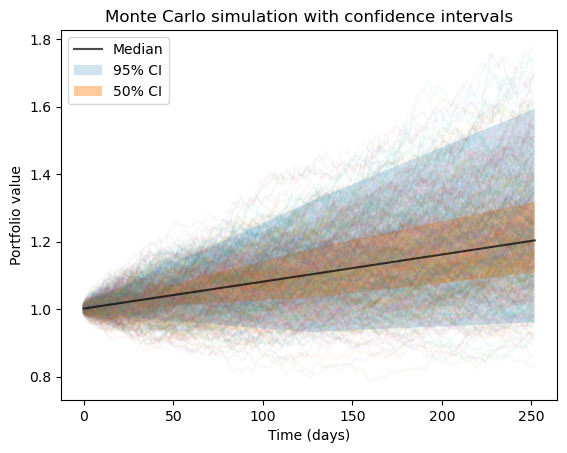

In [17]:
graph_2(sim_df)

N-asset portfolio risk and return calculation: https://youtu.be/Yqn5ypsCv3g?si=i7tPpsnSzk9BQLww <br>
Monte carlo simulation python: https://youtu.be/6-dhdMDiYWQ?si=xPIXBTUSb3Y6vbjw
Interpolate: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html and ChatGPT
Apply lambda: ChatGPT